In [215]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from typing import Union

from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd
import seaborn as sns

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo, ImageNode
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode


import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [217]:
claude_mm_default = BasicAnthropicLLM(model='claude-3-5-sonnet-20240620', temperature = 0.0)

In [218]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [219]:
fig_num = 2

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

In [220]:
query_tool = handler.query_engine_tool(metadata_filters=filters)

In [221]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [222]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [223]:
response = query_tool(prompt)
nodes = response.raw_output.source_nodes
figure_struct = output_parser.parse(response.content)

In [224]:
nodes

[NodeWithScore(node=TextNode(id_='816f492a-fb49-4eab-8c9c-7c0a71364724', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'Light delivery and imaging', 'experimental_variable_entities': ['light pulse duration', 'wavelength', 'power', 'photocurrent strength', 'light intensity'], 'fig_refs': ['Supplemental Figure 5', 'Figure 2e']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='973861f2-1885-42ea-bdbe-6f26b8bbae99', node_type=None, metadata={}, hash=None)}, text='Light delivery and imaging\n\nPatch-clamp recordings were done with short light pulses to measure photocurrents. Light pulse duration, wavelength, and power were varied depending on the experiment (as describe

In [225]:
# find figure image
for node in nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))
        source_figure_summary = node.node.text

In [226]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Panel: a

		Plot: Current traces and cell images
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Time', categorical=False)] dependent_variables=[Variable(name='Current', categorical=False), Variable(name='Fluorescence', categorical=False)]
	Panel: b

		Plot: Photocurrent strength
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Wavelength', categorical=True)] dependent_variables=[Variable(name='Peak photocurrent', categorical=False), Variable(name='Steady-state photocurrent', categorical=False)]
	Panel: c

		Plot: Off-kinetics decay rate
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='τoff', categorical=False)]
		Plot: Current traces inset
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Time', categorical=False)] dependent_variables=[Variable(name='Current', categorical=False)]
	Panel: d

		Plot

In [227]:
# select panel d (only one plot in panel)
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

In [228]:
class BoundingBox(BaseModel):
    left_x: float = Field(default = 0.0, description="The x-coordinate of the left side of the bounding box in the range 0.0 to 1.0")
    upper_y: float = Field(default = 0.0, description="The y-coordinate of the top side of the bounding box in the range 0.0 to 1.0")
    right_x: float = Field(default = 1.0, description="The x-coordinate of the right side of the bounding box in the range 0.0 to 1.0")
    lower_y: float = Field(default = 1.0, description="The y-coordinate of the bottom side of the bounding box")

In [229]:
output_parser = PydanticOutputParser(output_cls=BoundingBox)

In [230]:
PLOT_CROP_PROMPT = """
Provide a bounding box for panel {panel_name} (plot title/description: {plot_name}) in the provided figure. 
Be liberal with padding, we'd rather have extra that lose part of the panel."""

prompt = PromptTemplate(
    PLOT_CROP_PROMPT.format(panel_name=panel.name, plot_name=plot.name), 
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)

In [231]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [232]:
bbox = output_parser.parse(response.content[0].text)

In [233]:
padding = 0.1
bbox_cropped = BoundingBox()
bbox_cropped.left_x = np.max([0, bbox.left_x - padding])
bbox_cropped.upper_y = np.max([0, bbox.upper_y - padding])
bbox_cropped.right_x = np.min([1, bbox.right_x + padding])
bbox_cropped.lower_y = np.min([1, bbox.lower_y + padding])
bbox_cropped

BoundingBox(left_x=0.0, upper_y=0.5800000000000001, right_x=0.43000000000000005, lower_y=1.0)

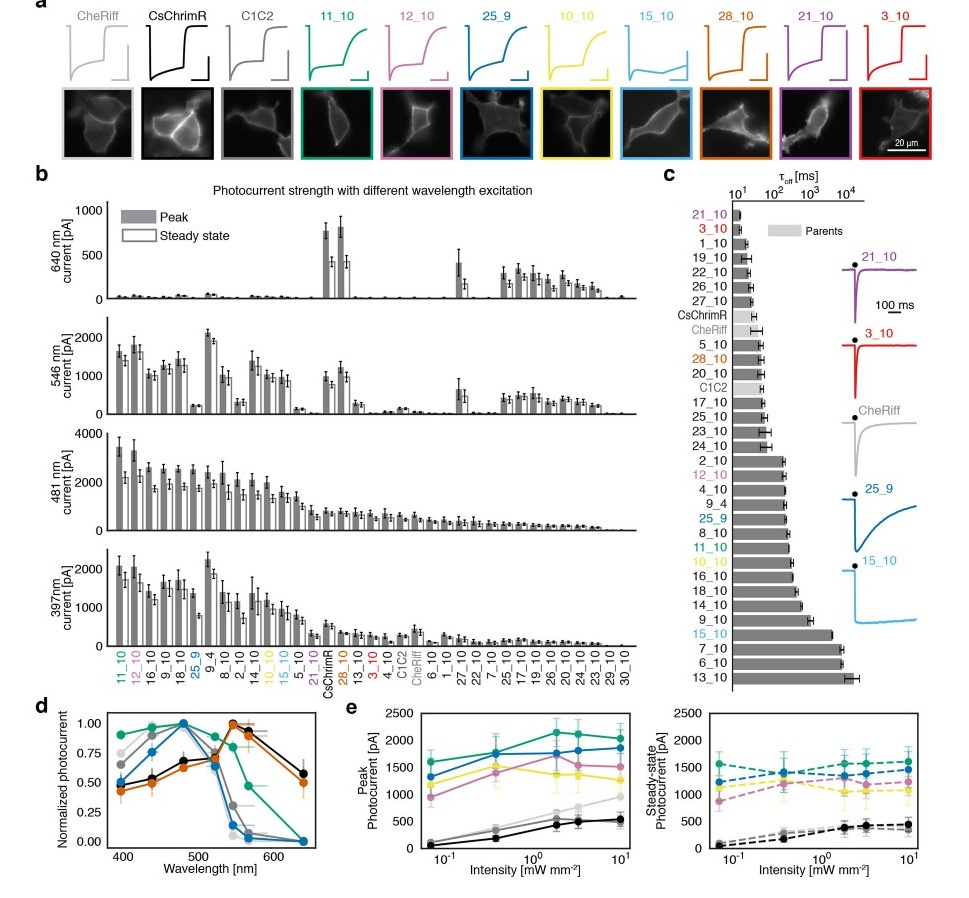

In [234]:
source_figure

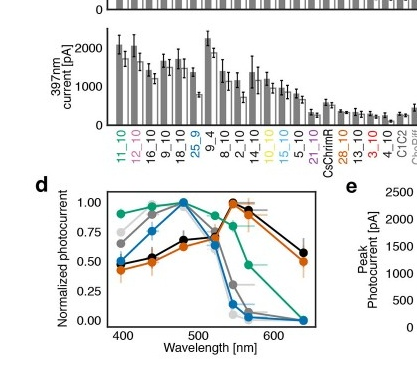

In [235]:
# use pillow to crop the image
fig_size = source_figure.size
bbox_px_vals = [bbox_cropped.left_x*fig_size[0], bbox_cropped.upper_y*fig_size[1], bbox_cropped.right_x*fig_size[0], bbox_cropped.lower_y*fig_size[1]]

# Crop the image using the extracted coordinates
cropped_img = source_figure.crop(bbox_px_vals)
cropped_img.save("cropped_img.png")
cropped_img = Image.open("cropped_img.png")
cropped_img

In [236]:
# make image node from cropped image
from plotreader.utils import image_to_base64

# convert PIL image to b64 encoded string
cropped_img_b64 = image_to_base64(cropped_img)

cropped_img_node = ImageNode(
    image=cropped_img_b64,
    image_url=None,
    metadata={
        "fig_refs": [f"Figure {fig_num}{panel.name}"],
    }
)

In [237]:
nodes.append(cropped_img_node)

In [238]:
class PlotInfo(BaseModel):
    plot_name: str = Field(description="The name of the plot")
    information: str = Field(description="Details that could be useful when interpretting to the plot")

class PanelInfo(BaseModel):
    panel_name: str = Field(description="The name of the panel")
    plots: list[PlotInfo] = Field(description="The plots in the panel")

class FigureInfo(BaseModel):
    figure_name: str = Field(description="The name of the figure")
    panels: list[PanelInfo] = Field(description="The panels in the figure")


In [183]:
# # let's try to consolidate the context into a summary and add important info we should consider for this figure
# FIGURE_SUMMARY_PROMPT = """
# You will be provided with Figure {fig_num} from a scientific paper, the relevant text from that paper regarding the figure, and a structured representation of the experiments in the plots of that figure.
# Your job is to consolidate information about the figure from the text and image with a focus on quantitative information about the variables in the experiments.
# The most important thing is that you include all quantitative information about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
# The goal is to use this information in place of the original text (though the image will always be available).
# If there are discrepancies, ambiguities, or potential type-os in source text, resolve in a manner that matches the information to the structured represenation of the figure below.

# Structured representation of the figure:
# {figure_desc_str}

# Retrieved text information:
# {context}
# """

# context = "\n\n".join(
#     [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
# )

# prompt = PromptTemplate(
#     FIGURE_SUMMARY_PROMPT.format(fig_num=fig_num, figure_desc_str=fig_description, context=context),
# ).format(llm=plotreader._MM_LLM)


In [184]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.schema import QueryBundle

In [185]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({panel_name}), and retrieved text from that paper regarding the figure.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: {plot_name}.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
You should ensure that the information is only referencing the plot of interesting by looking at the images, but only use this to filter information from the next, not to change it.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=3)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)


In [186]:
text_nodes

[NodeWithScore(node=TextNode(id_='82233ee2-8144-4d94-9181-fa263e11f609', embedding=None, metadata={'Header_1': 'Results', 'Header_2': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'Header_3': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'experimental_variable_entities': ['ChRger1', 'ChRger2', 'ChRger3', 'CoChR', 'ChR2(H134R)', 'rAAV-PHP.eB', 'light intensity', 'stimulation frequency', 'photocurrent strength', 'spike fidelity', 'laser power'], 'fig_refs': ['Figure 3i', 'Figure 3j', 'Figure 3k', 'Figure 3l', 'Figure 3g', 'Figure 3m', 'Figure 3n', 'Figure 4a', 'Supplemental Figure 10', 'Supplemental Table 6', 'Supplemental Table 5']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29d

In [187]:
rerankded_text_nodes

[NodeWithScore(node=TextNode(id_='eaec84a5-bbba-4ce1-a7fa-abd8bb9c59b8', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR.', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light intensity', 'stimulation frequency', 'light pulse width', 'photocurrent', 'spike fidelity', 'AAV vector', 'promoter', 'rAAV-PHP.eB', 'viral genome dose'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='eb6bd820-b9b0-466b-9471-804e104045df', node_type=None, metadata={

In [188]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)

In [189]:
details_text =response.content[0].text

In [190]:
print(response.content[0].text)

Based on the provided information, here are the details about the experimental variables used in the plot of Spike fidelity vs Light intensity (panel d):

Plot: Spike fidelity vs Light intensity

Independent variables:
1. Light intensity (mW mm^-2)
   - Categorical: False
   - Range: 10^-3 to 10^0 mW mm^-2 (log scale)

2. ChR variant
   - Categorical: True
   - Values: ChRger1, ChRger2, ChRger3, CoChR, ChR2

Dependent variable:
1. Spike fidelity (%)
   - Categorical: False
   - Range: 0 to 100%

Additional experimental details:
- Light pulse width: 5 ms
- Stimulation frequency: 2 Hz
- Promoter: hSyn
- Vector: rAAV-PHP.eB
- Delivery method: Cultured neurons
- Cell type: Not specified, likely general neuronal population

Plot style:
- Line graph
- Colors:
  ChRger1: RGB(255, 192, 203) (pink)
  ChRger2: RGB(0, 255, 255) (cyan)
  ChRger3: RGB(0, 255, 0) (green)
  CoChR: RGB(0, 0, 255) (blue)
  ChR2: RGB(128, 128, 128) (gray)
- Markers: 'o' (circles)
- X-axis: Log scale
- Y-axis: Linear sca

In [191]:

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of float."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

In [192]:


plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
"""
        
    else:
        var_cls = NumericVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity (mW mm^-2)' categorical=False
name='ChR variant' categorical=True


In [193]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': [255.0, 192.0, 203.0], 'ChRger2': [0.0, 255.0, 255.0], 'ChRger3': [0.0, 255.0, 0.0], 'CoChR': [0.0, 0.0, 255.0], 'ChR2': [128.0, 128.0, 128.0]})]

In [49]:
# detailed_plot_desc = plot_desc
# detailed_plot_desc += "\n\t\t\tIndependent Variables Details:"
# for iv in ivs_with_values:
#     detailed_plot_desc += f"\n\t\t\t\t{iv}"

# print(detailed_plot_desc)

Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False)]
			Independent Variables Details:
				name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
				name='ChR variant' label_type='color' values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], '11_10': [0.0, 255.0, 255.0], '12_10': [255.0, 0.0, 255.0], '25_9': [173.0, 216.0, 230.0]}


In [53]:
# # let's try to consolidate the context into a summary and add important info we should consider for this figure
# FIGURE_SUMMARY_PROMPT = """
# Are there any clear errors in this structured description of the data in Figure {fig_num}{panel_name}, plot {plot_name} when looking at the images of the plot?
# We do not care about small differences that don't affect the interpretation of the data (like small differences in the exact values of the variables).

# Here is some context to help you:

# {detailed_plot_desc}
# """

# prompt = FIGURE_SUMMARY_PROMPT.format(
#     fig_num=fig_num, panel_name=panel.name, plot_name=plot.name, detailed_plot_desc=detailed_plot_desc
#     ).replace("{","{{").replace("}","}}")
# prompt = PromptTemplate(
#     prompt,
# ).format(llm=plotreader._MM_LLM)


In [54]:
print(prompt)


Are there any clear errors in this structured description of the data in Figure 2d, plot Normalized photocurrent vs wavelength when looking at the images of the plot?
We do not care about small differences that don't affect the interpretation of the data (like small diffs in quantity or quality).

Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False)]
			Independent Variables Details:
				name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
				name='ChR variant' label_type='color' values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], '11_10': [0.0, 255.0, 255.0], '12_10': [255.0, 0.0, 255.0], '25_9': [173.0, 216.0, 230.0]}



In [55]:
# response = claude_mm_default.message(
#     prompt,
#     images = [cropped_img, source_figure]
# )
# print(response.content[0].text)
# data_revision_response = response.content[0].text

After examining the image of Figure 2d, there are a few clear errors in the structured description provided:

1. Wavelength values: The description lists 7 wavelength values, but the plot only shows 6 data points for each line. The wavelengths on the x-axis are approximately 400, 450, 500, 550, 600, and 650 nm.

2. ChR variant colors: The colors listed in the description don't match exactly with those in the image. For example:
   - CheRiff is shown in gray, not [128, 128, 128]
   - 11_10 is shown in teal/cyan, not [0, 255, 255]
   - 12_10 is shown in magenta/purple, not [255, 0, 255]
   - 25_9 is shown in green, not [173, 216, 230]

3. Missing variants: The description doesn't include all the ChR variants shown in the plot. It's missing at least one orange line that appears in the graph.

4. Y-axis range: The description doesn't mention that the y-axis (Normalized photocurrent) ranges from 0 to 1.00.

These discrepancies could significantly affect the interpretation of the data, espec

In [38]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
Your job is to extract the independent variables used in a particular plot in the panel: {fig_num}{panel_name} - {plot_name}.
You will be provided with an image cropped around the plot of interest.
The most important thing is that you include all details about the indepedent variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES. DO NOT REFERENCE FIGURE OR PANEL NAMES IN YOUR RESPONSE.
You may need to look to the provided information for clues about the values of the independent variables.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)

Structured representation of the plot experiment:
{plot_desc} 

Context parsed directly from figure:
{fig_parsed_text}

"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"


prompt = PromptTemplate(
    FIGURE_SUMMARY_PROMPT.format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name, plot_desc=plot_desc, fig_parsed_text=source_figure_summary),
).format(llm=plotreader._MM_LLM)


In [39]:
print(prompt)


Your job is to extract the independent variables used in a particular plot in the panel: 2d - Normalized photocurrent vs wavelength.
You will be provided with an image cropped around the plot of interest.
The most important thing is that you include all details about the indepedent variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES. DO NOT REFERENCE FIGURE OR PANEL NAMES IN YOUR RESPONSE.
You may need to look to the provided information for clues about the values of the independent variables.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)

Structured representation of the plot experiment:
Plot

In [40]:
response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)

In [41]:
image_details = response.content[0].text

In [42]:
print(response.content[0].text)

Based on the provided image and context, the independent variables for the normalized photocurrent vs wavelength plot are:

1. Wavelength: The x-axis shows wavelengths ranging from 400 nm to 600 nm.

2. ChR variant: Multiple ChR variants are represented by different colored lines:
   - CheRiff: Gray
   - C1C2: Gray
   - CsChrimR: Black
   - 11_10: Cyan
   - 12_10: Magenta
   - 25_9: Light blue
   - 10_10: Yellow
   - 15_10: Blue
   - 28_10: Orange
   - 21_10: Purple
   - 3_10: Red

The plot shows data points at specific wavelengths (400 nm, 500 nm, 550 nm, 600 nm) for each ChR variant, connected by lines. The y-axis represents the normalized photocurrent, with values ranging from 0 to 1.


In [62]:
iv.values.values()

dict_values([[128.0, 128.0, 128.0], [0.0, 0.0, 0.0], [128.0, 128.0, 128.0], [0.0, 255.0, 255.0], [255.0, 0.0, 255.0], [173.0, 216.0, 230.0], [255.0, 255.0, 0.0]])

/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_30095/2598441626.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')


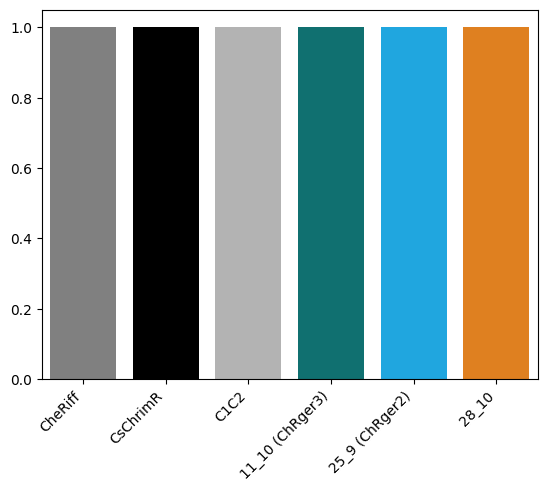

In [121]:
for iv in ivs_with_values:
    if isinstance(iv, CategoricalVariable):
        
        axes = sns.barplot(
            x = iv.values.keys(),
            y = np.ones(len(iv.values.keys())),
            hue = iv.values.keys(),
            palette = [np.array(v) for v in iv.values.values()]
        )
        # rotate x-labels
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')

        # show axes
    else:
        axes = sns.lineplot(
            x = iv.values,
            y = np.ones(len(iv.values)),
            marker = 'o',
        )
    

In [67]:
ivs_with_values_rev = []
for iv in ivs_with_values:
    IV_DETAILS_REVISION_PROMPT = """
We have previously extracted the information about the independent variable {var_name} and their values from Figure {fig_num}{panel_name}, plot {plot_name} using the structure provided below.
We have also found issues with that initial response. 
Given the inital response, the identified issues, and images of the source figure and plot, please revise the initial response.
IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

PREVIOUS RESPONSE:
{prev_response}

REVISION ADVICE:
{revision_advice}
""".format(
        var_name = iv.name,
        fig_num = fig_num,
        panel_name = panel.name, 
        plot_name = plot.name,
        prev_response = iv,
        revision_advice = data_revision_response,
    ).replace("{","{{").replace("}","}}")
    if isinstance(iv, CategoricalVariable):
        output_parser = PydanticOutputParser(output_cls=CategoricalVariable)
    else:
        output_parser = PydanticOutputParser(output_cls=NumericVariable)

    prompt = PromptTemplate(IV_DETAILS_REVISION_PROMPT, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values_rev.append(output_parser.parse(text))



In [68]:
ivs_with_values_rev

[NumericVariable(name='Wavelength', values=[400.0, 450.0, 500.0, 550.0, 600.0, 650.0], unit='nm'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'CheRiff': [128.0, 128.0, 128.0], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [128.0, 128.0, 128.0], 'ChR_11_10': [0.0, 255.0, 255.0], 'ChR_12_10': [255.0, 0.0, 255.0], 'ChR_25_9': [0.0, 128.0, 255.0], 'ChR_10_10': [255.0, 255.0, 0.0]})]

In [194]:
ivs_to_use = ivs_with_values

In [204]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
In Figure {fig_num}{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

And here is some information that could be useful:
{text_info}

Return your data using the following column schema: {schema}.
""".format(
    fig_num = fig_num,
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_to_use]),
    schema = ", ".join(df.columns),
    text_info = details_text,
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = claude_mm_default.message(
    prompt,
    images = [cropped_img]
)
panel_df = output_parser.parse(data_response.content[0].text).to_df(existing_df=df)


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [205]:
panel_df

,Light intensity (mW mm^-2),ChR variant,Spike fidelity (%)
0,0.001,ChRger1,0
1,0.003,ChRger1,5
2,0.010,ChRger1,60
3,0.030,ChRger1,95
4,0.100,ChRger1,100
5,0.300,ChRger1,100
6,1.000,ChRger1,100
7,0.001,ChRger2,0
8,0.003,ChRger2,15
9,0.010,ChRger2,80


[]

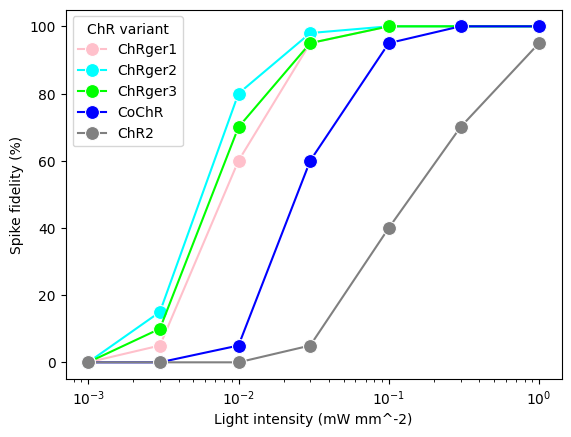

In [206]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v)/255 for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity (mW mm^-2)',
    y='Spike fidelity (%)',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.semilogx()


In [196]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)


ValueError: Could not interpret value `Wavelength` for `x`. An entry with this name does not appear in `data`.

After comparing the source figure and the recreated plot, I've identified the following three largest quantitative differences:

1. Spike fidelity values for ChRger1, ChRger2, and ChRger3 at 0.003 mW mm^-2: In the source figure, these values appear to be closer to 0%, especially for ChRger1. However, in the recreated plot, they are 5%, 15%, and 10% respectively. This is a systematic difference affecting multiple variants at the same light intensity.

2. Spike fidelity for CoChR at 0.03 mW mm^-2: In the source figure, this value appears to be around 40-45%, but in the recreated plot, it's set at 60%. This is a significant difference of about 15-20 percentage points.

3. Spike fidelity for ChR2 at 0.3 mW mm^-2: The source figure shows this value to be around 80-85%, while in the recreated plot, it's set at 70%. This represents a difference of about 10-15 percentage points.

These differences are specific and refer to particular data points. The first difference is especially notable as i

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, here are the three largest quantitative differences I've identified:

1. ChRger2 spike fidelity at 0.01 mW mm^-2: In the recreated plot, this value is 80%, while in the source figure it appears to be closer to 90-95%. This is a difference of about 10-15 percentage points.

2. CoChR spike fidelity at 0.03 mW mm^-2: The recreated plot shows this value as 45%, but in the source figure, it looks to be around 60-65%. This is a difference of approximately 15-20 percentage points.

3. ChR2 spike fidelity at 0.3 mW mm^-2: In the recreated plot, this value is 85%, whereas in the source figure it appears to be closer to 75-80%. This represents a difference of about 5-10 percentage points.

These differences are specific to individual data points and don't represent a systematic shift across all categories. However, it's worth noting that in general, the recreated plot seems to have slightly lower values for the middle range of light inten

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, I've identified the following three largest quantitative differences:

1. ChRger2 spike fidelity at 0.01 mW mm^-2: In the recreated plot, the value is 92%, while in the source figure, it appears to be closer to 80-85%. This is a difference of about 7-12 percentage points.

2. ChRger3 spike fidelity at 0.01 mW mm^-2: The recreated plot shows 75%, but the source figure indicates a value closer to 65-70%. This represents a difference of about 5-10 percentage points.

3. CoChR spike fidelity at 0.03 mW mm^-2: The recreated plot shows 62%, while the source figure suggests a value closer to 50-55%. This is a difference of approximately 7-12 percentage points.

These differences seem to be most pronounced in the middle range of light intensities (0.01 to 0.03 mW mm^-2) and affect multiple ChR variants. Adjusting these values could bring the recreation closer to the source figure across several data points.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, I've identified the following three largest quantitative differences:

1. ChRger2 spike fidelity at 0.01 mW mm^-2: In the recreated plot, the value is 82%, while in the source figure, it appears to be closer to 90-95%. This is a difference of about 8-13 percentage points.

2. CoChR spike fidelity at 0.03 mW mm^-2: The recreated plot shows a value of 52%, but the source figure indicates a value closer to 40-45%. This represents a difference of approximately 7-12 percentage points.

3. ChR2 spike fidelity at 0.3 mW mm^-2: In the recreated plot, the value is 78%, whereas in the source figure, it appears to be around 70-75%. This is a difference of about 3-8 percentage points.

These differences are specific to individual data points and variants. There doesn't seem to be a consistent pattern of discrepancy across all variants that could be corrected with a single adjustment. Each of these points would likely need to be addressed in

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, here are the three largest quantitative differences I've identified:

1. ChRger2 spike fidelity at 0.01 mW mm^-2: In the recreated plot, the value is 92%, while in the source figure it appears to be closer to 80-85%. This is a difference of about 7-12 percentage points.

2. CoChR spike fidelity at 0.03 mW mm^-2: The recreated plot shows 42%, but the source figure shows a value closer to 30-35%. This is a difference of about 7-12 percentage points.

3. ChR2 spike fidelity at 0.3 mW mm^-2: The recreated plot shows 72%, while the source figure appears to show a value closer to 60-65%. This is a difference of about 7-12 percentage points.

These differences seem to be consistent across multiple data points, suggesting a general trend of slightly higher spike fidelity values in the recreated plot compared to the source figure. This could potentially be corrected by applying a small downward adjustment to many of the spike fidelity va

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, here are the three largest quantitative differences I've identified:

1. ChRger2 values at low light intensities: In the source figure, ChRger2 (cyan line) shows higher spike fidelity at lower light intensities compared to the recreated plot. Specifically, at 0.01 mW mm^-2, the source figure shows a spike fidelity of about 95%, while the recreated plot shows 85%.

2. CoChR values at mid-range light intensities: The CoChR curve (dark blue) in the source figure rises more gradually than in the recreated plot. At 0.03 mW mm^-2, the source figure shows a spike fidelity of about 20-25%, while the recreated plot shows 35%.

3. ChR2 values at high light intensities: In the source figure, the ChR2 curve (gray) reaches higher spike fidelity at the highest light intensities compared to the recreated plot. At 1 mW mm^-2, the source figure shows nearly 100% spike fidelity, while the recreated plot shows 95%.

These differences appear to be 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot, I've identified the following three largest quantitative differences:

1. ChRger2 curve: In the recreated plot, the spike fidelity for ChRger2 at 0.01 mW mm^-2 is 95%, while in the source figure it appears to be closer to 80-85%. This is a significant difference of about 10-15 percentage points.

2. CoChR curve: The recreated plot shows a spike fidelity of 22% for CoChR at 0.03 mW mm^-2, but in the source figure, this value appears to be closer to 30-35%. This represents a difference of about 8-13 percentage points.

3. ChR2 curve: In the recreated plot, the spike fidelity for ChR2 at 0.3 mW mm^-2 is 65%, while in the source figure it appears to be slightly lower, around 55-60%. This is a difference of about 5-10 percentage points.

These differences are specific to individual data points and variants, but they represent the largest quantitative discrepancies between the source and recreated plots. Correcting these points would 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


KeyboardInterrupt: 

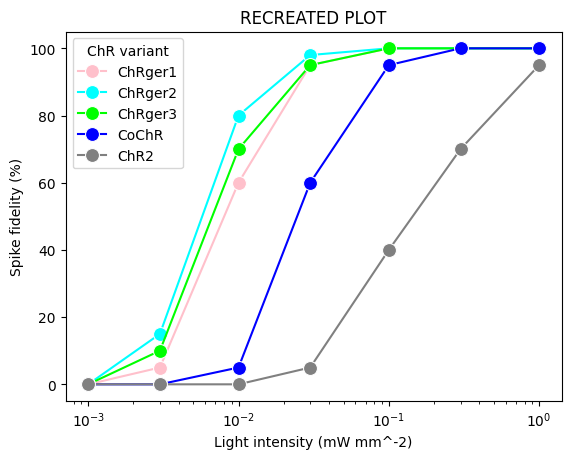

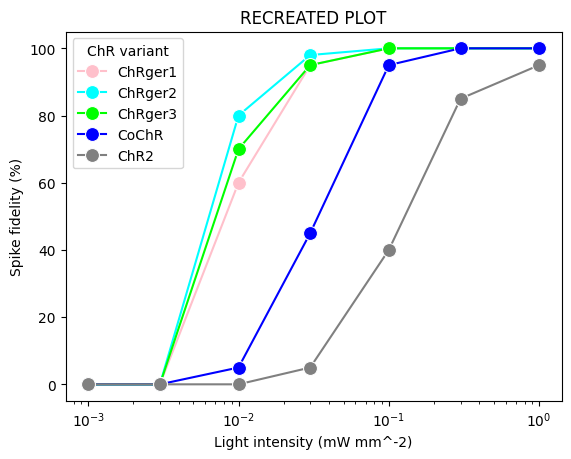

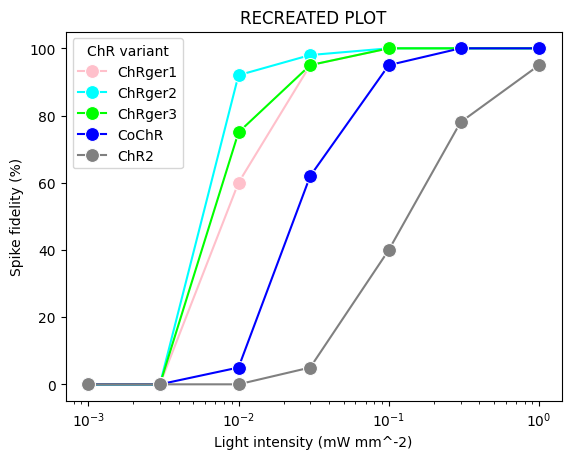

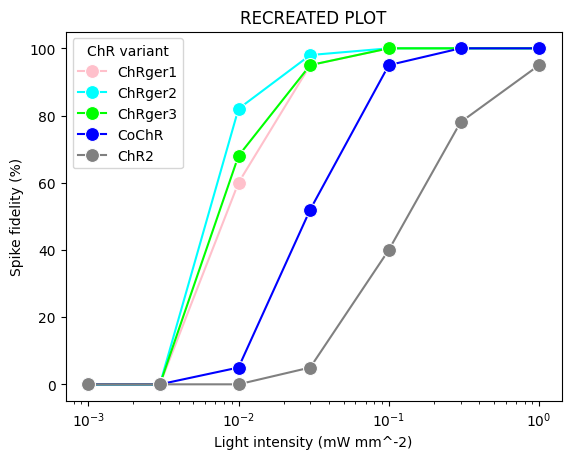

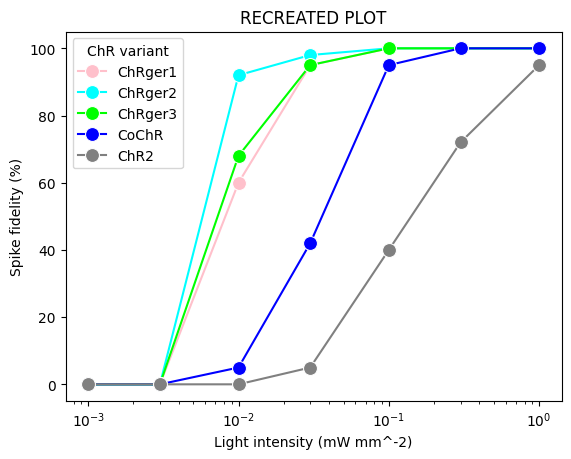

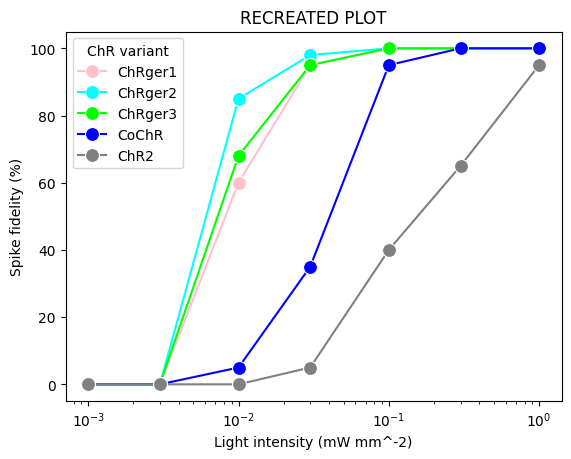

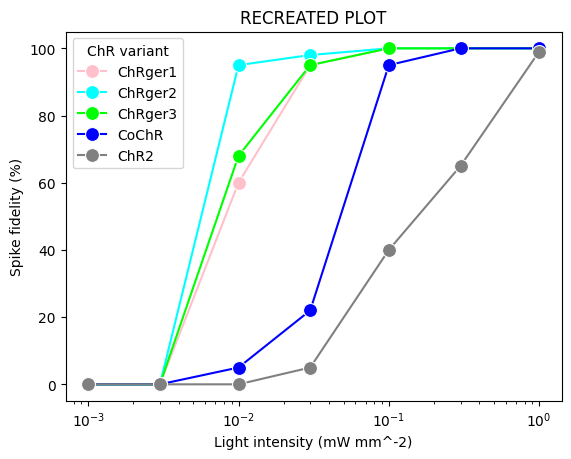

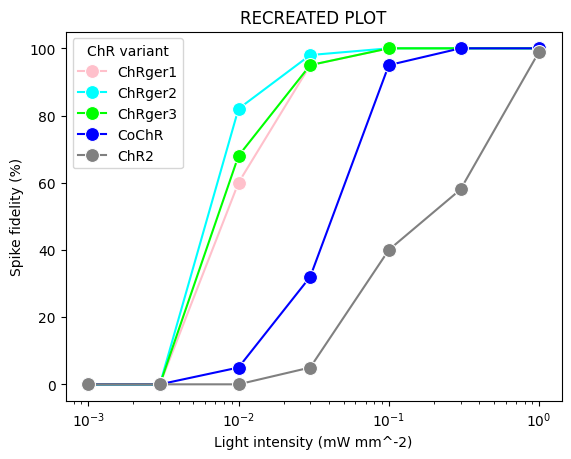

In [213]:
from matplotlib import pyplot as plt
from PIL import Image

chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255 for k,v in chr_variant_iv.values.items()]

fig, axes = plt.subplots()
# sns.lineplot(
#     data=panel_df,
#     x='Wavelength',
#     y='Normalized photocurrent',
#     hue='ChR variant',
#     marker='o',
#     hue_order=chr_variant_order,
#     markersize=10,
#     palette=palette,
#     ax=axes
# )
sns.lineplot(
    data=panel_df,
    x='Light intensity (mW mm^-2)',
    y='Spike fidelity (%)',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
axes.semilogx()
axes.set_title(f"RECREATED PLOT")
# axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

refined_feedback = "No previous changes."
claude_mm_critique = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.1)
for iter in range(20):

    


    prompt_base = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
(Note: the recreation may vary in stylistic choices (e.g. color, linestyle) and in properties like axes ranges or aspect ratio but this not what we are concerned with.)
List the three largest quantitative differences between the values of the data in the rereation versuse source figure.
If possible, prioritize general differences that are common across many categories such that they can all be corrected together.
Be specific and refer to specific quantities and values. Do not suggest difference that change the number of rows.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm_critique.message(prompt_base, images = [cropped_img, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    refined_feedback = feedback_loop

    # refined_feedback_response = claude_mm_default.message(
    #     f"Choose the two most important changes from the suggested list that will result in the largest quantitative improvement in matching the source figure: \n{feedback_loop}",
    #     images = [cropped_img, generated_img_loop]
    # )
    # refined_feedback = refined_feedback_response.content[0].text
    # print(refined_feedback)



    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

And here is some information that could be useful:
{text_info}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
Reference the source text in the context if you think there is information that will inform these changes (e.g changing independent variable values).
This could mean scaling or shift all or a subset of the rows and/or columns, but do not add or delete rows.
Please let any specific changes inform nearby values if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
        text_info = details_text,
    ).replace("{","<").replace("}",">")
    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = claude_mm_default.message(prompt, images = [cropped_img, generated_img_loop])
    panel_df_loop = output_parser.parse(data_response_loop.content[0].text).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Wavelength',
    #     y='Normalized photocurrent',
    #     hue='ChR variant',
    #     marker='o',
    #     hue_order=chr_variant_order,
    #     markersize=10,
    #     palette=palette,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity (mW mm^-2)',
        y='Spike fidelity (%)',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    axes.semilogx()
    axes.set_title(f"RECREATED PLOT")
    # axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

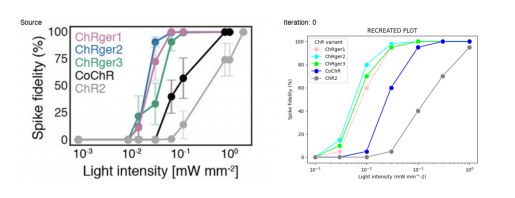

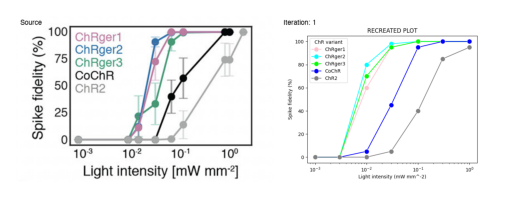

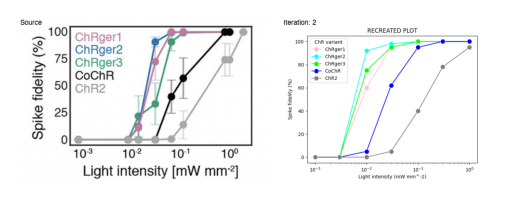

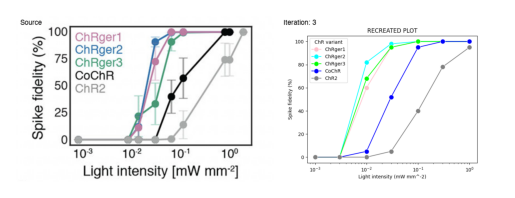

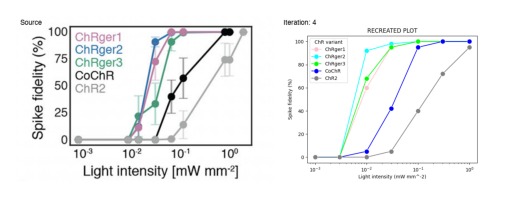

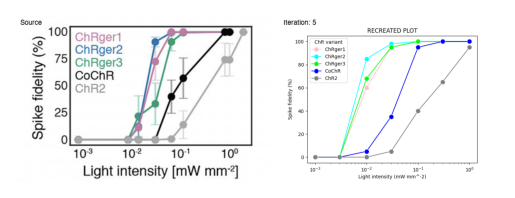

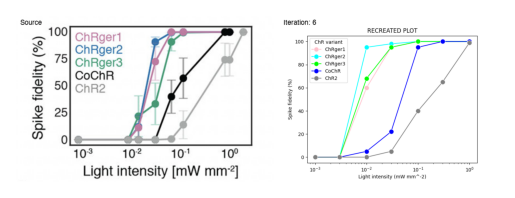

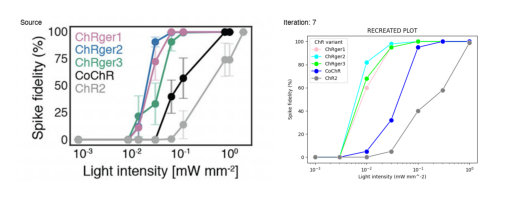

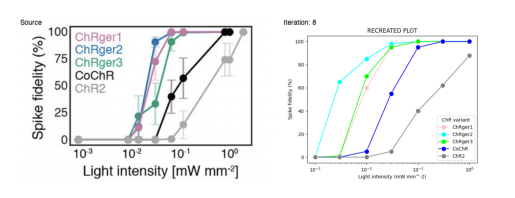

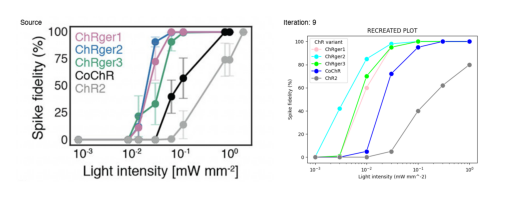

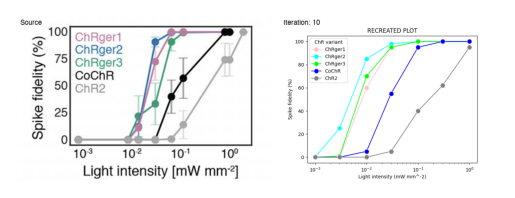

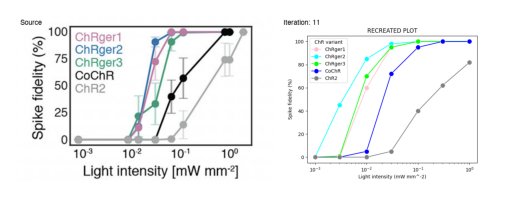

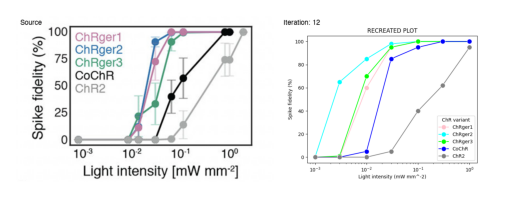

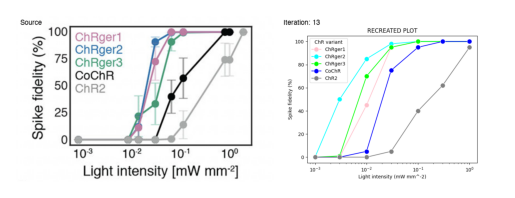

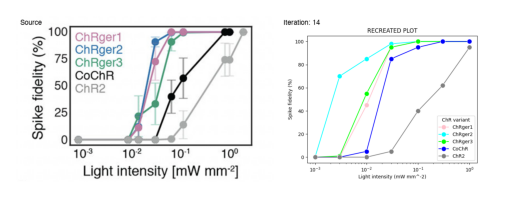

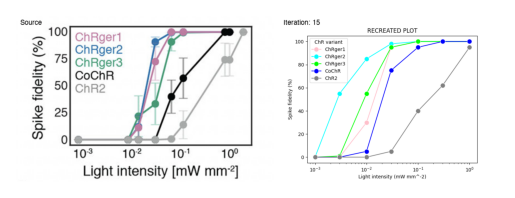

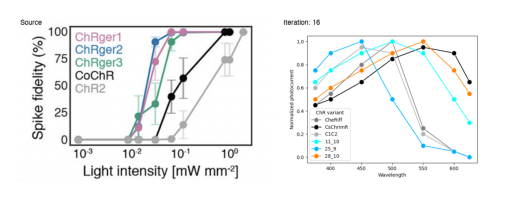

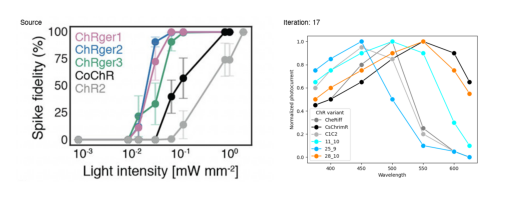

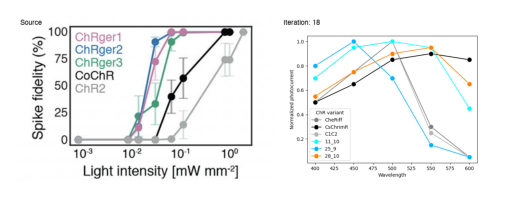

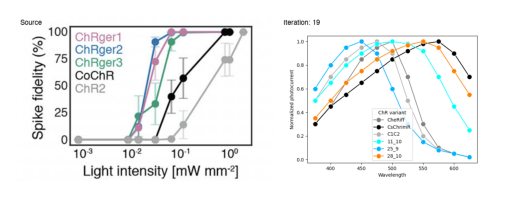

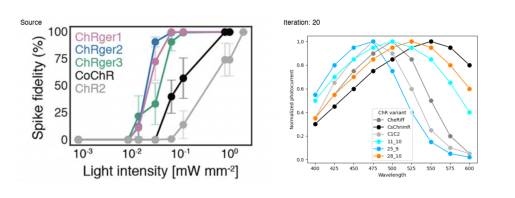

MP4 video saved as 'comparison.mp4'


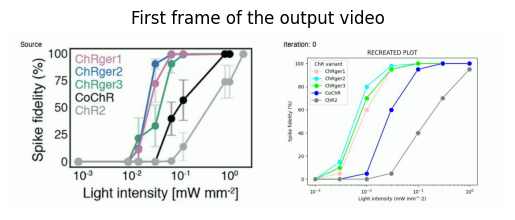

In [214]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")
